In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from okada_wrapper import dc3dwrapper

import celeri
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

In [2]:
COMMAND_FILE_NAME = "../data/config/western_north_america_config.json"
model = celeri.build_model(COMMAND_FILE_NAME)

2025-06-12 14:39:44.284 | INFO     | celeri.model:read_data:52 - Reading data files
2025-06-12 14:39:44.291 | SUCCESS  | celeri.model:read_data:65 - Read: ../data/segment/western_north_america_segment_cascdip.csv
2025-06-12 14:39:44.292 | SUCCESS  | celeri.model:read_data:70 - Read: ../data/block/western_north_america_block.csv
2025-06-12 14:39:44.360 | SUCCESS  | celeri.mesh:from_params:468 - Read: ../data/mesh/cascadia.msh
2025-06-12 14:39:44.363 | SUCCESS  | celeri.model:read_data:107 - Read: ../data/station/western_north_america_station.csv
2025-06-12 14:39:44.363 | INFO     | celeri.model:read_data:123 - No mogi_file_name
2025-06-12 14:39:44.364 | INFO     | celeri.model:read_data:146 - No sar_file_name


In [3]:
def fault_parameters_to_okada_format(sx1, sy1, sx2, sy2, dip, D, bd):
    """
    This function takes fault trace, dip, and locking depth information
    and calculates the anchor coordinates, length, width and strike of
    the fault plane following (1985).

    Arguments:
        sx1 : x coord of fault trace endpoint 1
        sy1 : y coord of fault trace endpoint 1
        sx2 : x coord of fault trace endpoint 2
        sy2 : y coord of fault trace endpoint 2
        dip : dip of fault plane (degrees)
        D : fault locking depth
        bd : burial depth (top "locking depth")

    Returned variables:
        strike : stike of fault plane
        L : fault length
        W : fault width
        ofx : x coord of fault anchor
        ofy : y coord of fault anchor
        ofxe : x coord of other buried corner
        ofye : y coord of other buried corner
        tfx : x coord of fault anchor (top relative)
        tfy : y coord of fault anchor (top relative)
        tfxe : x coord of other buried corner (top relative)
        tfye : y coord of other buried corner (top relative)
    """

    okada_parameters = dict()
    okada_parameters["strike"] = (
        np.arctan2(sy1 - sy2, sx1 - sx2) + np.pi
    )  # This is by convention
    okada_parameters["L"] = np.sqrt((sx2 - sx1) ** 2 + (sy2 - sy1) ** 2)
    okada_parameters["W"] = (D - bd) / np.sin(np.deg2rad(dip))

    # Calculate fault segment anchor and other buried point
    okada_parameters["ofx"] = sx1 + D / np.tan(np.deg2rad(dip)) * np.sin(
        np.deg2rad(okada_parameters["strike"])
    )
    okada_parameters["ofy"] = sy1 - D / np.tan(np.deg2rad(dip)) * np.cos(
        np.deg2rad(okada_parameters["strike"])
    )
    okada_parameters["ofxe"] = sx2 + D / np.tan(np.deg2rad(dip)) * np.sin(
        np.deg2rad(okada_parameters["strike"])
    )
    okada_parameters["ofye"] = sy2 - D / np.tan(np.deg2rad(dip)) * np.cos(
        np.deg2rad(okada_parameters["strike"])
    )

    # Calculate fault segment anchor and other buried point (top relative)
    okada_parameters["tfx"] = sx1 + bd / np.tan(np.deg2rad(dip)) * np.sin(
        np.deg2rad(okada_parameters["strike"])
    )
    okada_parameters["tfy"] = sy1 - bd / np.tan(np.deg2rad(dip)) * np.cos(
        np.deg2rad(okada_parameters["strike"])
    )
    okada_parameters["tfxe"] = sx2 + bd / np.tan(np.deg2rad(dip)) * np.sin(
        np.deg2rad(okada_parameters["strike"])
    )
    okada_parameters["tfye"] = sy2 - bd / np.tan(np.deg2rad(dip)) * np.cos(
        np.deg2rad(okada_parameters["strike"])
    )

    return okada_parameters


"""
Calculates the elastic displacement partial derivatives based on the Okada
formulation, using the source and receiver geometries defined in
dicitonaries segment and stations. Before calculating the partials for
each segment, a local oblique Mercator project is done.
"""

segment = model.segment
station = model.station
config = model.config

n_stations = len(model.station)
n_segments = len(model.segment)
G = np.zeros((3 * n_stations, 3 * n_segments))
v1 = np.zeros(n_segments)
v2 = np.zeros(n_segments)
v3 = np.zeros(n_segments)

# Loop through each segment and calculate displacements
for i in range(1):
    print(i)

    # Local map projection
    projection = celeri.get_segment_oblique_projection(
        segment.lon1[i], segment.lat1[i], segment.lon2[i], segment.lat2[i]
    )
    station_x, station_y = projection(station.lon, station.lat)
    segment_x1, segment_y1 = projection(segment.lon1[i], segment.lat1[i])
    segment_x2, segment_y2 = projection(segment.lon2[i], segment.lat2[i])

    # Calculate fault parameters in Okada form
    okada_parameters = fault_parameters_to_okada_format(
        segment_x1,
        segment_y1,
        segment_x2,
        segment_y2,
        segment.dip[i],
        segment.locking_depth[i],
        segment.burial_depth[i],
    )

    # Translate observation coordinates relative to fault anchor
    # Rotation observation coordinates to remove strike
    rotation_matrix = np.array(
        [
            [
                np.cos(np.deg2rad(okada_parameters["strike"])),
                -np.sin(np.deg2rad(okada_parameters["strike"])),
            ],
            [
                np.sin(np.deg2rad(okada_parameters["strike"])),
                np.cos(np.deg2rad(okada_parameters["strike"])),
            ],
        ]
    )

0


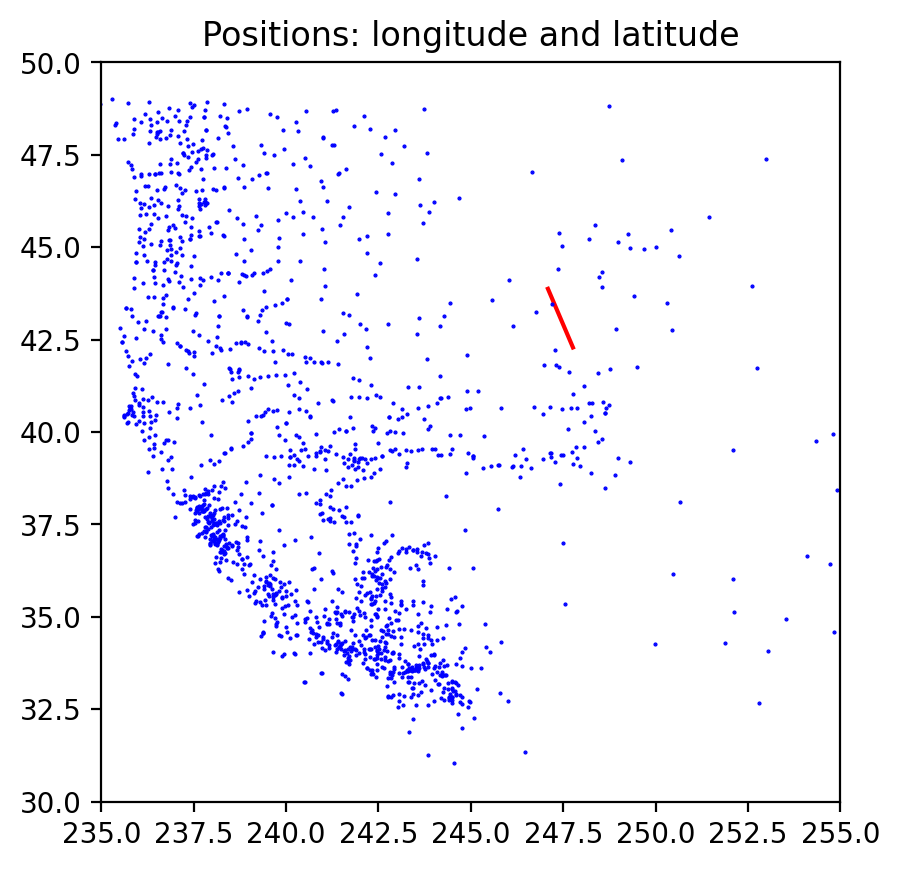

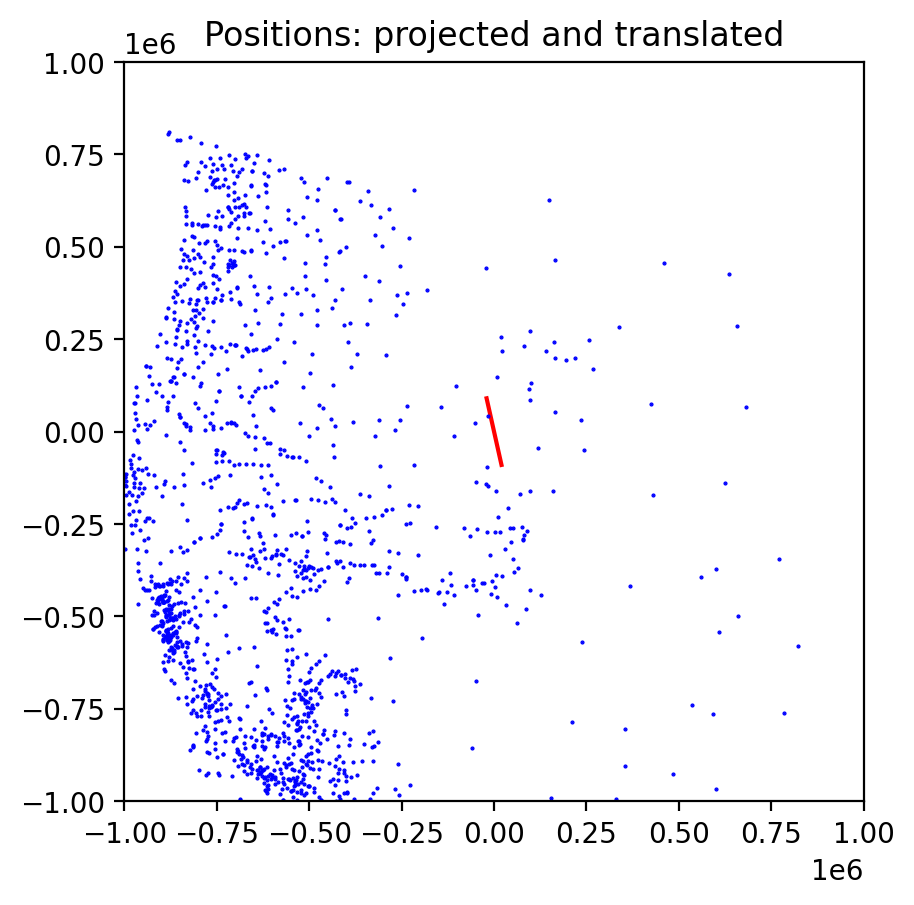

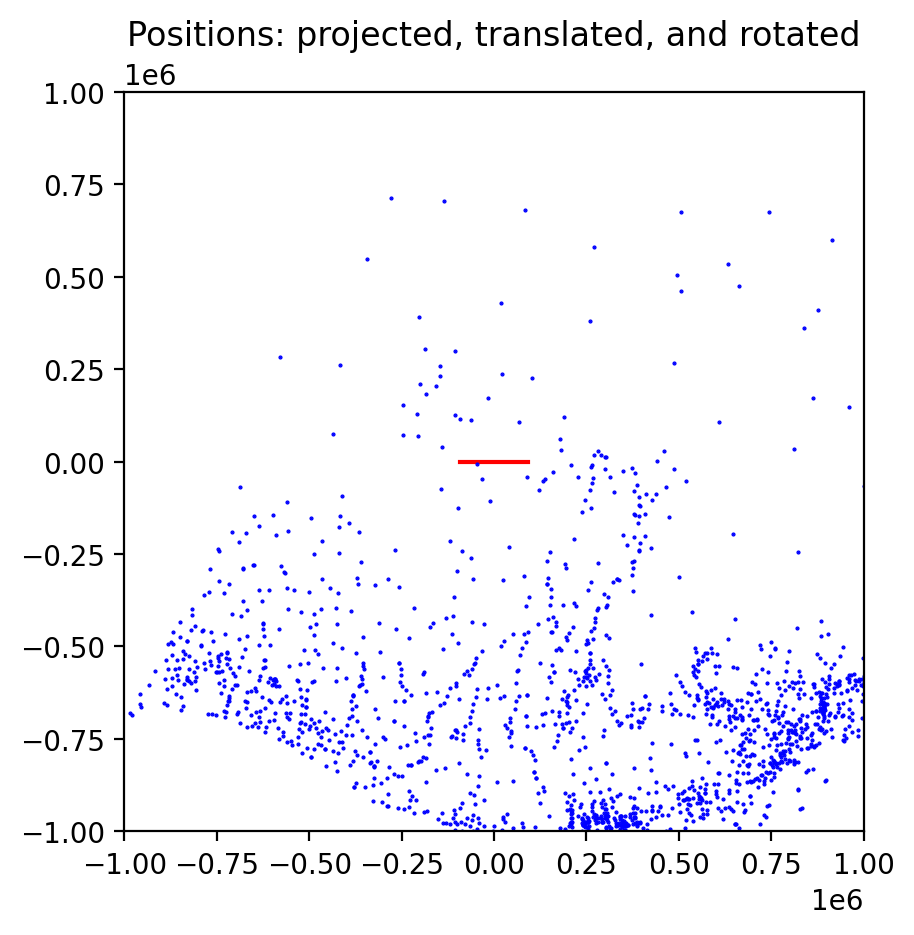

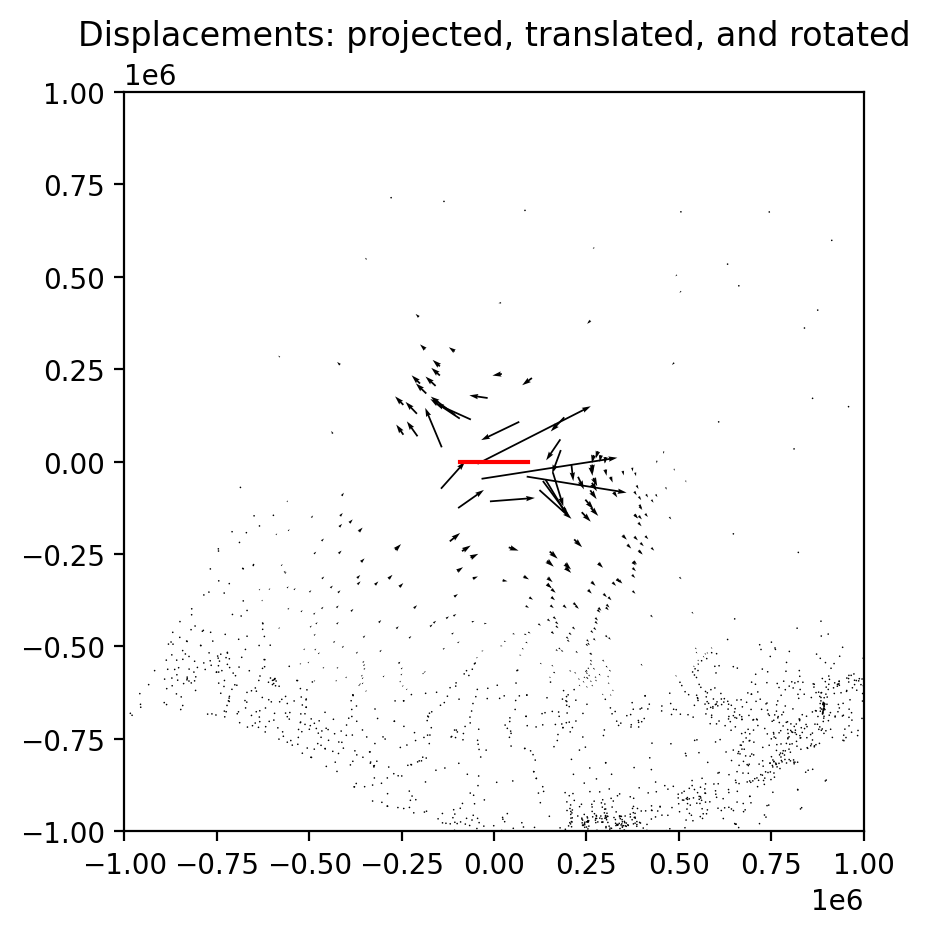

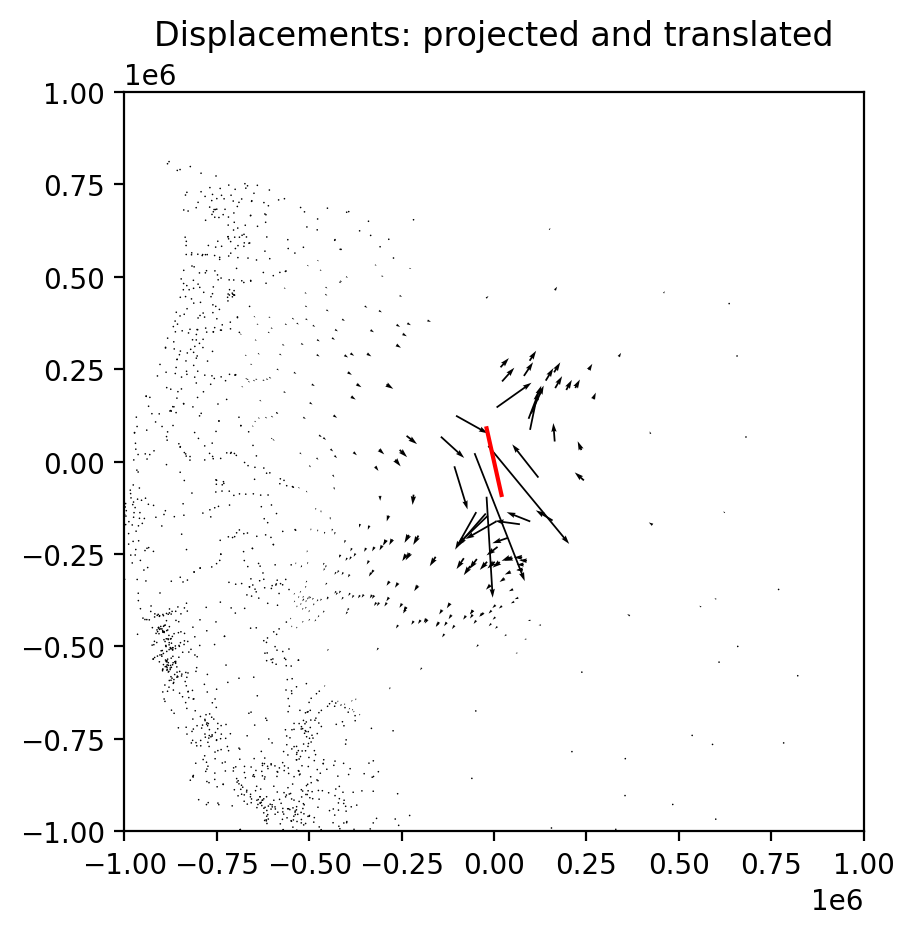

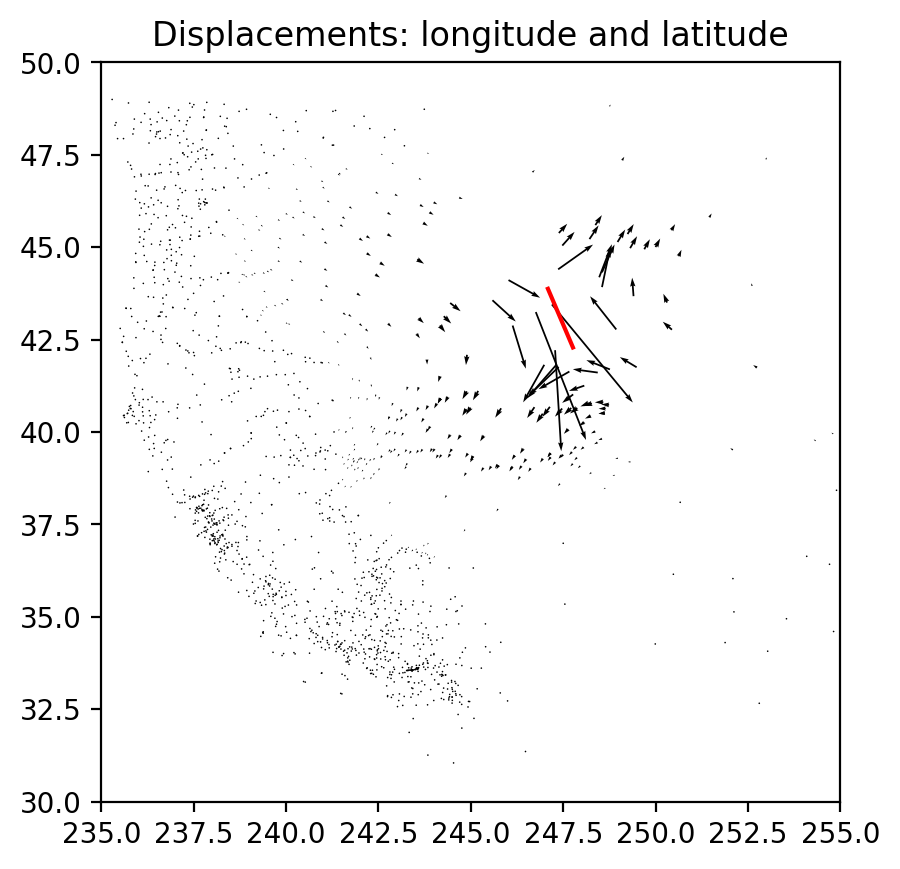

In [4]:
# TODO: Locking depths are currently meters rather than KM in inputfiles!!!
# TODO: Do I really need two rotation matrices?
# TODO: Is there another XYZ to ENU conversion needed?
KM2M = 1.0e3
i = 0
segment.locking_depth.values[i] *= KM2M
segment.burial_depth.values[i] *= KM2M

# Project coordinates to flat space using a local oblique Mercator projection
projection = celeri.get_segment_oblique_projection(
    segment.lon1[i], segment.lat1[i], segment.lon2[i], segment.lat2[i], True
)
station_x, station_y = projection(station.lon, station.lat)
segment_x1, segment_y1 = projection(segment.lon1[i], segment.lat1[i])
segment_x2, segment_y2 = projection(segment.lon2[i], segment.lat2[i])

# Calculate geometric fault parameters
segment_strike = np.arctan2(segment_y2 - segment_y1, segment_x2 - segment_x1)  # radians
segment_length = np.sqrt(
    (segment_y2 - segment_y1) ** 2.0 + (segment_x2 - segment_x1) ** 2.0
)
segment_up_dip_width = (segment.locking_depth[i] - segment.burial_depth[i]) / np.sin(
    np.deg2rad(segment.dip[i])
)

# Translate stations and segment so that segment mid-point is at the origin
segment_x_mid = (segment_x1 + segment_x2) / 2.0
segment_y_mid = (segment_y1 + segment_y2) / 2.0
station_x -= segment_x_mid
station_y -= segment_y_mid
segment_x1 -= segment_x_mid
segment_x2 -= segment_x_mid
segment_y1 -= segment_y_mid
segment_y2 -= segment_y_mid

# Unrotate coordinates to eliminate strike, segment will lie along y = 0
# np.einsum guidance from: https://stackoverflow.com/questions/26289972/use-numpy-to-multiply-a-matrix-across-an-array-of-points
rotation_matrix = np.array(
    [
        [np.cos(segment_strike), -np.sin(segment_strike)],
        [np.sin(segment_strike), np.cos(segment_strike)],
    ]
)
un_rotation_matrix = np.array(
    [
        [np.cos(-segment_strike), -np.sin(-segment_strike)],
        [np.sin(-segment_strike), np.cos(-segment_strike)],
    ]
)
station_x_rotated, station_y_rotated = np.hsplit(
    np.einsum("ij,kj->ik", np.dstack((station_x, station_y))[0], un_rotation_matrix), 2
)
segment_x1_rotated, segment_y1_rotated = un_rotation_matrix.dot(
    [segment_x1, segment_y1]
)
segment_x2_rotated, segment_y2_rotated = un_rotation_matrix.dot(
    [segment_x2, segment_y2]
)

# Elastic displacements due to fault slip from Okada 1985
alpha = (config.material_lambda + config.material_mu) / (
    config.material_lambda + 2 * config.material_mu
)
u_x = np.zeros_like(station_x)
u_y = np.zeros_like(station_x)
u_z = np.zeros_like(station_x)
for j in range(len(station)):
    _, u, _ = dc3dwrapper(
        alpha,  # (lambda + mu) / (lambda + 2 * mu)
        [station_x_rotated[j], station_y_rotated[j], 0],  # (meters) observation point
        -segment.locking_depth[i],  # (meters) depth of the fault origin
        segment.dip[
            i
        ],  # (degrees) the dip-angle of the rectangular dislocation surface
        [
            -segment_length / 2,
            segment_length / 2,
        ],  # (meters) the along-strike range of the surface (al1,al2 in the original)
        [
            0,
            segment_up_dip_width,
        ],  # (meters) along-dip range of the surface (aw1, aw2 in the original)
        [1.0, 0.0, 0.0],
    )  # (meters) strike-slip, dip-slip, tensile-slip
    u_x[j] = u[0]
    u_y[j] = u[1]
    u_z[j] = u[2]


# Rotate displacement to account for projected fault strike
u_x_un_rotated, u_y_un_rotated = np.hsplit(
    np.einsum("ij,kj->ik", np.dstack((u_x, u_y))[0], rotation_matrix), 2
)


plt.figure()
plt.plot([segment.lon1[i], segment.lon2[i]], [segment.lat1[i], segment.lat2[i]], "-r")
plt.plot(station.lon, station.lat, ".b", markersize=1)
plt.xlim([235, 255])
plt.ylim([30, 50])
plt.gca().set_aspect("equal", adjustable="box")
plt.title("Positions: longitude and latitude")
plt.show()

plt.figure()
plt.plot([segment_x1, segment_x2], [segment_y1, segment_y2], "-r")
plt.plot(station_x, station_y, ".b", markersize=1)
plt.xlim([-1e6, 1e6])
plt.ylim([-1e6, 1e6])
plt.gca().set_aspect("equal", adjustable="box")
plt.title("Positions: projected and translated")
plt.show()

plt.figure()
plt.plot(
    [segment_x1_rotated, segment_x2_rotated],
    [segment_y1_rotated, segment_y2_rotated],
    "-r",
)
plt.plot(station_x_rotated, station_y_rotated, ".b", markersize=1)
plt.xlim([-1e6, 1e6])
plt.ylim([-1e6, 1e6])
plt.gca().set_aspect("equal", adjustable="box")
plt.title("Positions: projected, translated, and rotated")
plt.show()

plt.figure()
plt.plot(
    [segment_x1_rotated, segment_x2_rotated],
    [segment_y1_rotated, segment_y2_rotated],
    "-r",
)
# plt.plot(station_x_rotated, station_y_rotated, '.b', markersize=1)
plt.quiver(
    station_x_rotated, station_y_rotated, u_x, u_y, scale=1e-1, scale_units="inches"
)
plt.xlim([-1e6, 1e6])
plt.ylim([-1e6, 1e6])
plt.gca().set_aspect("equal", adjustable="box")
plt.title("Displacements: projected, translated, and rotated")
plt.show()

plt.figure()
plt.plot([segment_x1, segment_x2], [segment_y1, segment_y2], "-r")
# plt.plot(station_x, station_y, '.b', markersize=1)
plt.quiver(
    station_x,
    station_y,
    u_x_un_rotated,
    u_y_un_rotated,
    scale=1e-1,
    scale_units="inches",
)
plt.xlim([-1e6, 1e6])
plt.ylim([-1e6, 1e6])
plt.gca().set_aspect("equal", adjustable="box")
plt.title("Displacements: projected and translated")
plt.show()

plt.figure()
plt.plot([segment.lon1[i], segment.lon2[i]], [segment.lat1[i], segment.lat2[i]], "-r")
# plt.plot(station_x, station_y, '.b', markersize=1)
plt.quiver(
    station.lon,
    station.lat,
    u_x_un_rotated,
    u_y_un_rotated,
    scale=1e-1,
    scale_units="inches",
)
plt.xlim([235, 255])
plt.ylim([30, 50])
plt.gca().set_aspect("equal", adjustable="box")
plt.title("Displacements: longitude and latitude")
plt.show()